In [1]:
#hide
import os
from pathlib import Path
import time
import matplotlib.pyplot as plt

import pandas as pd
from fastai.vision.all import *

In [2]:
# Change this path to adapt to where you downloaded the data
BASE_PATH = Path("/storage/geolifeclef-2021/")
DATA_PATH = BASE_PATH / "data"

# Create the path to save submission files
SUBMISSION_PATH = Path("submissions")
os.makedirs(SUBMISSION_PATH, exist_ok=True)

In [3]:
import sys

sys.path.append( '../' )
from GLC.data_loading.common import load_patch
from GLC.plotting import visualize_observation_patch
from GLC.metrics import top_30_error_rate
from GLC.metrics import top_k_error_rate_from_sets
from GLC.metrics import predict_top_30_set, predict_top_k_set

PATCHES_PATH = DATA_PATH / "patches/"
patch = load_patch(10000000, PATCHES_PATH)

print("Number of data sources: {}".format(len(patch)))
print("Arrays shape: {}".format([p.shape for p in patch]))
print("Data types: {}".format([p.dtype for p in patch]))

Number of data sources: 4
Arrays shape: [(256, 256, 3), (256, 256), (256, 256), (256, 256)]
Data types: [dtype('uint8'), dtype('uint8'), dtype('int16'), dtype('uint8')]


# El plan

Para cada observación hay que asociar las etiquetas de especies. Esto requiere construir un indice de coordenadas para asociar al patch respectivo todas las etiquetas necesarias.

1. Crear datablock para leer las imagenes rgb:
    1. Como leer las etiquetas
    1. Cómo asociar los archivos de imagen
1. 

In [4]:
#load_patch??

Obtener la ruta de archivo

In [5]:
def get_x(r):
    """Loads the patch data associated to an observation id

    Parameters
    ----------
    observation_id : integer
        Identifier of the observation.
    patches_path : string / pathlib.Path
        Path to the folder containing all the patches.
    landcover_mapping : 1d array-like
        Facultative mapping of landcover codes, useful to align France and US codes.
    return_arrays : boolean
        If True, returns all the patches as Numpy arrays (no PIL.Image returned).

    Returns
    -------
    patches : tuple of size 4 containing 2d array-like objects
        Returns a tuple containing all the patches in the following order: RGB, Near-IR, altitude and landcover.
    """
    observation_id = str(r['observation_id'])

    region_id = observation_id[0]
    if region_id == "1":
        region = "fr"
    elif region_id == "2":
        region = "us"
    else:
        raise ValueError("Incorrect 'observation_id' {}, can not extract region id from it".format(observation_id))

    subfolder1 = observation_id[-2:]
    subfolder2 = observation_id[-4:-2]

    filename = Path(PATCHES_PATH) / region / subfolder1 / subfolder2 / observation_id

    rgb_filename = filename.with_name(filename.stem + "_rgb.jpg")
    
    return rgb_filename

def get_y(r):
    species_id = r['species_id']
    
    return species_id

def splitter(df):
    train = df.index[df['subset'] == 'train'].tolist()
    valid = df.index[df['subset'] != 'train'].tolist()
    return train,valid

def get_observations(data_path):
    df_fr = pd.read_csv(data_path / "observations" / "observations_fr_train.csv",
                        sep=";", index_col="observation_id")
    df_us = pd.read_csv(data_path / "observations" / "observations_us_train.csv",
                        sep=";", index_col="observation_id")
    
    df = pd.concat((df_fr, df_us))
    
    return df

def generate_submission_file(filename, corrected_observation_ids, s_pred):
    s_pred = [
        " ".join(map(str, pred_set))
        for pred_set in s_pred
    ]
    
    df = pd.DataFrame({
        "Id": corrected_observation_ids,
        "Predicted": s_pred
    })
    df.to_csv(filename, index=False)
    
def get_test_observations(data_path):
    df_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";",
                             low_memory=False, dtype={'observation_id': str})
    df_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";",
                             low_memory=False, dtype={'observation_id': str})
    
    df_test = pd.concat((df_fr_test, df_us_test))
    return df_test

In [9]:
def training_setup(load_model=True, load_dls= True, data_limit = None, model_file_name='geolife-21-cnn'):            
    save_cbs = SaveModelCallback(every_epoch=True, with_opt=True, fname=model_file_name)
    
    if load_model:
        load_dls = True
    
    if load_dls: 
        dls = load_pickle(f'{model_file_name}_dataloaders.pkl')

    if load_model:
        learn = cnn_learner(dls, resnet34, cbs=save_cbs)
        
        model_file = get_last_model_file(model_file_name)
        learn = learn.load(model_file)
    else:
        
        if not load_dls:
            df = get_observations(DATA_PATH)
            df = df.reset_index()

            if data_limit != None:
                df = df.sample(n=data_limit, random_state = 1)
                df = df.reset_index(drop=True)
            
            not_train_labels = set(df[df.subset == 'val'].species_id).difference(df[df.subset == 'train'].species_id)
            cond = df.species_id.isin(not_train_labels)
            remove_idx = np.where(cond)[0]

            df = df.drop(index=remove_idx)
            df = df.reset_index(drop=True)

            dblock = DataBlock((ImageBlock, CategoryBlock),
                       get_x = get_x,
                       get_y = get_y,
                       splitter=splitter)

            dls = dblock.dataloaders(df, bs=256)
            save_pickle(f'{model_file_name}_dataloaders.pkl', dls)
            save_pickle(f'{model_file_name}_observations_train_df.pkl', df)

        learn = cnn_learner(dls, resnet34, cbs=save_cbs)
    
    return learn

def get_last_model_file(model_file='geolife-21-cnn', dir_name='models'):
    
    file = sorted(Path(dir_name).glob(f'{model_file}*.pth'),
                  key = os.path.getmtime,
                  reverse=True)[0]
                           
    return file.stem


In [7]:
def test_setup(new=False): 
    
    if not new:
        df_val = load_pickle('observations_test_df.pkl')
    else:
        df = get_observations(DATA_PATH)
        df = df.reset_index()
        df_val = df[df.subset == 'val']
        save_pickle('observations_test_df.pkl', df_val)
        
    return df_val

In [8]:
def score_test(learn, df_val):
    dl_t = learn.dls.test_dl(df_val, bs=128)
    preds, _ = learn.get_preds(dl=dl_t)
    
    preds_ids = array([learn.dls.vocab[pred] for pred in predict_top_k_set(preds, 30)])
    
    y_val = df_val.species_id.astype(int)
    score_val = top_k_error_rate_from_sets(y_val, preds_ids)
    print("Top-30 error rate: {:.1%}".format(score_val))

In [ ]:
df = get_observations(DATA_PATH)
df = df.reset_index()
df.head()

In [ ]:
test_run = False
if test_run:
    df = df.sample(n=1_300_000, random_state = 1)
    df = df.reset_index(drop=True)

In [ ]:
not_train_labels = set(df[df.subset == 'val'].species_id).difference(df[df.subset == 'train'].species_id)
len(not_train_labels)

In [ ]:
cond = df.species_id.isin(not_train_labels)
remove_idx = np.where(cond)[0]

In [ ]:
df = df.drop(index=remove_idx)
df = df.reset_index(drop=True)

In [ ]:
dblock = DataBlock((ImageBlock, CategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter=splitter)

In [ ]:
#dsets = dblock.datasets(df)
#dsets.train[0]

In [ ]:
#dsets.valid[0]

In [ ]:
df = load_pickle('observations_train_df.pkl')
dls = load_pickle('dataloaders.pkl')

In [ ]:
dls = dblock.dataloaders(df, bs=256)

In [ ]:
dls.show_batch(nrows=1, ncols=3)

In [ ]:
save_pickle('observations_train_df.pkl', df)
save_pickle('dataloaders.pkl', dls)

In [ ]:
#%time failed = verify_images(df.apply(get_x, axis=1))
#failed

In [ ]:
#import csv

#with open('failed_imgs.csv', 'w') as f:
#    writer = csv.writer(f)
#    writer.writerow(failed)


In [ ]:
#interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
#interp.plot_top_losses(3, nrows=1)

In [ ]:
#interp.print_classification_report()

In [ ]:
learn = cnn_learner(dls, resnet34)

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
lr_steep

In [ ]:
save_cbs = SaveModelCallback(every_epoch=True, with_opt=True, fname='geolife-21-cnn')

In [ ]:
learn = learn.load('geolife-21-cnn_1')

In [11]:
learn = training_setup(load_model=False, load_dls=False, model_file_name='geolife-21-cnn-full')

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
df_val = test_setup()

In [13]:
score_test(learn, df_val)

Top-30 error rate: 99.9%


0.17378008365631104

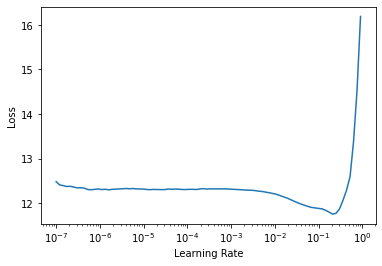

In [14]:
lr_min, lr_steep = learn.lr_find()
lr_steep

In [15]:
learn.fit_one_cycle(1, lr_steep)

epoch,train_loss,valid_loss,time
0,7.755381,7.497278,1:57:23


In [18]:
score_test(learn, df_val)

Top-30 error rate: 85.0%


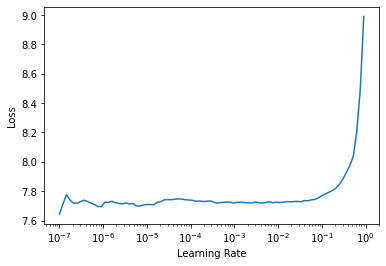

In [19]:
lr_min, lr_steep = learn.lr_find()

In [20]:
lr_min, lr_steep

(7.585775847473997e-08, 4.786300905834651e-06)

In [17]:
learn.opt.frozen_idx

2

In [21]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [22]:
learn.unfreeze()
learn.fit_one_cycle(1, lr_max=slice(1e-6, 1e-2))

epoch,train_loss,valid_loss,time
0,7.536519,7.302029,2:33:11


In [23]:
score_test(learn, df_val)

Top-30 error rate: 81.8%


In [24]:
df_test = get_test_observations(DATA_PATH)
#df_test = df_test.reset_index()
#df_test.observation_id = df_test.observation_id.astype(int)
df_test.head()

,observation_id,latitude,longitude
0,10782781,43.601788,6.940195
1,10364138,46.241711,0.683586
2,10692017,45.181095,1.533459
3,10222322,46.938450,5.298678
4,10241950,45.017433,0.960736


In [25]:
df_test_obs_id_mapping = pd.read_csv(BASE_PATH / "test_observation_ids_mapping.csv", sep=";")

In [26]:
dl_t = learn.dls.test_dl(df_test, bs=256)
preds, _ = learn.get_preds(dl=dl_t)
preds_ids = array([learn.dls.vocab[pred] for pred in predict_top_k_set(preds, 30)])

# Generate the submission file
generate_submission_file(SUBMISSION_PATH/"fastai_cnn_rbg.csv", df_test_obs_id_mapping["Id"], preds_ids)

In [27]:
!kaggle competitions submit -c geolifeclef-2021 -f {SUBMISSION_PATH/"fastai_cnn_rbg.csv"} -m "fastai cnn submission"

100%|██████████████████████████████████████| 5.68M/5.68M [00:01<00:00, 3.97MB/s]
Successfully submitted to GeoLifeCLEF 2021 - LifeCLEF 2021 x FGVC8